# What kind of Beer do you want?

# Names

- George Liu, A15836054
- Xinyao Yi, A59019592
- Yingnan Yang, A16018172

### TODO List:
- randomized grid search
- l1/l2 regularization term/penalty for feature selection
- add more visualization
- explain model selection more
- conclusion

Make sure to focus on model selection
explain choice of activation functions, models, train test validation split, etc.


# Abstract
For adults, beer is one of the most highly consumed beverages; wouldn't you want to find a beer that is best for you? In order to do this, we want to examine how people rate beers. This includes things such as alcohol percentage, smell, and taste. Our goal is to build a model that predicts the ratings of beer given these attributes/features, extend the model to also recommend beers based upon your own preferences to these features.

Once we filter our dataset with the necessary features, we will train a baseline linear regression model and then a more complex fully connected neural network to see how it performs, using metrics such as RMSE, MAE, and R2 correlation coefficient. These metrics will help us determine the best model, and in turn allow us to recommend the best beer for you.

# Background
Our research problem is pretty unique in that researches don’t look into a topic like this. Mostly, this is because this topic is not super important to globalization and technological improvements. There are some works that are similar in topic, but none are academic. 

One way people use this dataset is to research the types of preferences people have in beer, things like how much foam a person wants, how much alcohol percentage is in the drink, etc. This mostly is used for improving the sales of beer and crafting the best drink. <sup>[1](#preferences)</sup>

Others have used beer reviews as a way for classification, being easily able to classify a beer into some categories for ease and also increases sales. <sup>[2](#classification)</sup>

A similar drink to beer is wine, and they are experimenting with computer vision to find when the optimal time is to use the ingredients, aka harvesting the grapes. A similar application can be used on barley, the ingredient to make beer. <sup>[3](#beer)</sup>

# Problem Statement/Research Problem
We aim to suggest the best beer for you based upon common beer preferences; things such as alcohol level, appearence, bitterness, etc. In the process of doing this, we will also aim to predict ratings on a scale 1-5, based upon these preferences; which can be replicated through our model architecture (there is no randomness). This problem is both quantifiable (as our predicted ratings we can get a definite number), and also measurable, through our error metrics that we present below.

# Dataset

https://www.kaggle.com/datasets/rdoume/beerreviews
This dataset can be found above at the link provided. It around 1.5 million beer reviews, and 13 total features. Each sample will consist of something similar to the name of the drink, a few columns representing the preferences of beers like alcohol level, and then the overall review rating. For our data, we need preprocess by filtering out useless columns and also selecting columns that can easily fit into our neural network architecture (for example getting columns that are integers/floats). Additionally, we will also have to one hot encode features that are important but categorical variables, for instance beer style. We also should drop any sample that is empty in the columns that we find useful.

To create our training set and test set, we need to first extract the overall rating score from the dataset as our y values (labels). Then, we extract all the columns that we find important and use that as our X. Then we can use test_train split to get the necessary proportions for our model to be generalizable. We can also split into a validation set, because we have so much data.

Below, you will be able to see how we pre processed our data.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.tree import DecisionTreeRegressor, plot_tree

2023-03-07 23:12:51.027280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 23:12:51.663363: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 23:12:51.663429: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 23:12:54.453048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
df = pd.read_csv('beer_reviews.csv')

In [3]:
df = df.dropna()

In [4]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


Creating a beer dictionary to pull up the names later.


In [5]:
beer_dict = dict(zip(df['beer_beerid'],df['beer_name']))

Getting the true review score

In [7]:
y = df.loc[:, 'review_overall']

In [8]:
df = df.drop(['brewery_id','brewery_name','review_time','review_profilename', 'beer_name','review_overall'],axis=1)

Need to one hot encode beer style

In [9]:
one_hot = pd.get_dummies(df['beer_style'])
df = pd.concat([df, one_hot], axis=1)
X = df.drop('beer_style', axis=1)

In [10]:
X.head()

,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,Altbier,American Adjunct Lager,American Amber / Red Ale,American Amber / Red Lager,...,Scotch Ale / Wee Heavy,Scottish Ale,Scottish Gruit / Ancient Herbed Ale,Smoked Beer,Tripel,Vienna Lager,Weizenbock,Wheatwine,Winter Warmer,Witbier
0,2.0,2.5,1.5,1.5,5.0,47986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.5,3.0,3.0,3.0,6.2,48213,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.5,3.0,3.0,3.0,6.5,48215,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,3.5,2.5,3.0,5.0,47969,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.5,4.0,4.0,4.5,7.7,64883,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X.dtypes

review_aroma         float64
review_appearance    float64
review_palate        float64
review_taste         float64
beer_abv             float64
                      ...   
Vienna Lager           uint8
Weizenbock             uint8
Wheatwine              uint8
Winter Warmer          uint8
Witbier                uint8
Length: 110, dtype: object

Note: We have a huge number of columns/features because of one hot encoding, which is why we selected to use decision trees as our baseline model, since they are not affected by the number of features while linear regression is

Splitting data into train, test, and validation. We can do this because we have so much data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [13]:
# convert everything to float for ease of use
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Proposed Solution:
We will first create a baseline decision tree model to get a feel for how it performs. We don't expect this to be great, because it will train slow compared to a neural network and is prone to overfitting since we haven't done any particular model selection on it. However, it will help determine the relationship between features and help select which features are the most important to help other models. 

From these results, we will create a fully connected neural network, which is useful because it can use backpropogation to fix previous misclassifications. This will make the model much more accurate. 

Finally, using the neural network, we will create a basic recommendation system that takes input from the user and inputs into our model to predict. We will need to add some logic to return the name of the beer that the model prediction corresponds to.

# Evaluation Metrics:

Our model isn't doing any classification, we already know all drinks that we predict are going to be beers. That means things like confusion matricies, F1 score, precision, etc. are not applicable. Instead, we would have to use things like Mean Absolute Error, Root Mean Squared Error, and R2 correlation coefficients to evaluate our models. 

MAE is less sensitive to outliers than other metrics and is interpretable while RMSE penalizes the large errors. We will take both of these factors into account when choosing the best model and analyzing our results. Further, we can also use R2 correlation coefficient to help assess how good our predicted model is on the data.

# Preliminary Results:

Here, we will train our baseline decision tree and see the results.

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [14]:
model = DecisionTreeRegressor(max_depth=3)

In [15]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3)

In [16]:
feature_importances = model.feature_importances_
feature_importances = sorted(zip(X.columns, feature_importances))
max(feature_importances)

('review_taste', 0.985284179045517)

We can see in our model, the most important feature is the taste. However, it is taking way too much percentage, the other columns should have some weight. This is something to consider when we implement our further models.

In [17]:
y_pred = model.predict(X_val)

In [18]:
y_pred[:5]

array([4.2398467 , 3.6422907 , 3.6422907 , 4.02011732, 4.02011732])

In [19]:
y_test[:5]

array([4. , 4.5, 5. , 4. , 4.5], dtype=float32)

In [20]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.6820952104504717

In [21]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0.9143309128078987

In [22]:
r2 = r2_score(y_test, y_pred)
r2

-0.6231856243974903

Our baseline model obviously doesn't perform great, so we want to hypertune the parameters using random gridsearch. We choose to use random because it increases speed of training (since we are doing this on datahub). Also, it helps prevent overfitting.


TODO: not finished

In [23]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

In [24]:
# param_dist = {"max_depth": [3, 5, 7, 10, None],
#               "min_samples_split": randint(2, 20),
#               "min_samples_leaf": randint(1, 20)}

In [25]:
# model = DecisionTreeRegressor()

In [26]:
# random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)


In [27]:
# random_search.fit(X_train, y_train)

In [28]:
# best_model = random_search.best_estimator_

# Ethics/Privacy:

There is definitely bias when in this dataset. We say this because as humans, we don't really rate things 0 or 5 on a 0-5 scale. Unless something is super bad or super good, we probably would rate it in between something like 3.5 to 4.5. This can severely affect our model predictions, but doesn't really have a good solution for it. 

Additionally, the ratings of some samples may occur when a person is already drunk, causing them to rate much higher or lower than if they were sober. It may also depend on how much fun they had while drunk. This also is sampling error, which we can't do much about.

# Team Expectations

* Be available on the weekends to work together if neccessary, otherwise individually complete assigned work during weekday
* Inform all team members through group chat on updates/something is pushed to github
* Finish all required parts at least 2 days before deadline is due

# Project Timeline Proposal


| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/16  |  1 PM |  Brainstorm topics/questions (all)  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 2/17  |  10 AM |  Do background research on topic and come up with basic model (George) | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 2/20  | 10 PM  | Edit, finalize, and submit proposal; Search for datasets (All)  | Assign group members to lead each specific part   |
| 3/1  | 6 PM  | Begin Neural Network architecture design/programming(George) | Discuss Analysis Plan   |
| 3/4 | 12 PM  | Write recommendation system(George) | Discuss/edit project code; Complete project |
| 3/12  | 12 PM  | Draft results/conclusion/discussion (Xinyao/Yingnan)| Discuss/edit full project |
| 3/19  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes

<a name="preferences">1</a>: AI of Things, one Telefonica Tech´s business unit. “The Use of AI and Machine Learning in the Beer Industry.” Think Big/Business, 18 June 2021, https://business.blogthinkbig.com/the-use-of-ai-and-machine-learning-in-the-beer-industry/. <br>

<a name="classification">2</a>: da Costa, Nattane Luíza, et al. “A Review on the Application of Chemometrics and Machine Learning Algorithms to Evaluate Beer Authentication - Food Analytical Methods.” SpringerLink, Springer US, 26 Sept. 2020, https://link.springer.com/article/10.1007/s12161-020-01864-7. 


<a name="beer">3</a>: Editor, MathWorks. “Making Better Beer and Wine with Data and Machine Learning.” Medium, MathWorks, 23 Sept. 2020, https://medium.com/mathworks/making-better-beer-and-wine-with-data-and-machine-learning-dd04459f53b7. 

# Fully Connected Neural Network

In [16]:
from keras.models import Sequential
from keras.layers import Dense

In [20]:
# model selection
model = Sequential()
model.add(Dense(64, input_shape=(110,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

### Model Selection

We purposely decided to use relu and linear activation functions because we are dealing with a regression task. Relu allows us to train very efficiently and linear activation function doesn't provide any bound restrictions on our predictions, which is what we want.

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
22778/22778 [==============================] - 112s 5ms/step - loss: 2385.6274 - val_loss: 2.2356
Epoch 2/5
22778/22778 [==============================] - 108s 5ms/step - loss: 0.7596 - val_loss: 0.2451
Epoch 3/5
22778/22778 [==============================] - 117s 5ms/step - loss: 0.2671 - val_loss: 0.3252
Epoch 4/5
22778/22778 [==============================] - 119s 5ms/step - loss: 0.2199 - val_loss: 0.1914
Epoch 5/5
22778/22778 [==============================] - 119s 5ms/step - loss: 0.2069 - val_loss: 0.2343


In [23]:
model.save("beer_nn")

INFO:tensorflow:Assets written to: beer_nn/assets


INFO:tensorflow:Assets written to: beer_nn/assets


In [15]:
# model = load_model('beer_nn')

2023-03-07 23:14:15.422903: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 23:14:15.423000: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 23:14:15.423076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dsmlp-jupyter-g9liu): /proc/driver/nvidia/version does not exist
2023-03-07 23:14:15.424058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Evaluate the model on the test set
y_pred = model.predict(X_val)
y_pred = np.clip(y_pred, 1, 5)

9491/9491 [==============================] - 12s 1ms/step


In [17]:
mae = mean_absolute_error(y_val, y_pred)
mae

0.38041948756805294

In [18]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.4841526274085052

In [19]:
r2 = r2_score(y_val, y_pred)
r2

0.542729517274215

In [20]:
abs_error = np.abs(np.array(y_val) - np.array(y_pred).flatten())

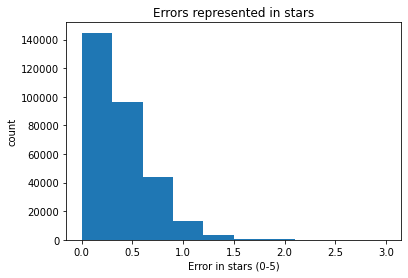

In [21]:
plt.hist(abs_error, bins=10, range=(0,3))
plt.ylabel('count')
plt.xlabel('Error in stars (0-5)')
plt.title('Errors represented in stars')
plt.show()

We can see our model performs much better than our baseline model, most of the error falls in the range between 0-0.5 stars.

Now, let's see what our model determines the most important feature is at each layer.

In [22]:
weights = model.layers[0].get_weights()[0]
most_important_features = np.argmax(weights, axis=0)
X.columns[np.argmax(most_important_features)]

'Dunkelweizen'

In [23]:
weights = model.layers[1].get_weights()[0]
most_important_features = np.argmax(weights, axis=0)
X.columns[np.argmax(most_important_features)]

'beer_abv'

In [24]:
weights = model.layers[2].get_weights()[0]
most_important_features = np.argmax(weights, axis=0)
X.columns[np.argmax(most_important_features)]

'review_palate'

In [25]:
weights = model.layers[3].get_weights()[0]
most_important_features = np.argmax(weights, axis=0)
print(X.columns[np.argmax(most_important_features)])
print(np.max(most_important_features))

beer_abv
15


We can see at the beginning, something like 'Dunkelweitzen' is the most important feature due to not fully being trained, but by the end, 'beer_abv' is the most important at 15%. This makes sense, because being the alcohol level logically definitely plays apart on your rating (a person will rate it higher/lower depending on if they want to be drunk or not). Additionally, the weight percentage is also more logical than our baseline, where its most heavy weight was 98%. 

# Building Recommendation System From Model 

Choosing to build recommendation system based on our most heavily weighted feature.

In [26]:
feature_means = X.mean()

In [27]:
abv_input = float(input('What alcohol percentage (0-100) do you want? '))

What alcohol percentage (0-100) do you want? 7


In [28]:
feature_means['beer_abv'] = abv_input
user_input = feature_means.values.reshape(1, -1)
beer_ratings = model.predict(user_input)[0][0]
print("Predicted beer rating for beers where it has 7% abv level is ",beer_ratings)

1/1 [==============================] - 0s 117ms/step
Predicted beer rating for beers where it has 7% abv level is  3.6465135


In [32]:
df['rating_difference'] = abs(y - beer_ratings)
df = df.sort_values('rating_difference')
top_ten=df[:10]
df_closest = top_ten.iloc[(top_ten['beer_abv']-abv_input).abs().argsort()[:1]]
beer_id = df_closest['beer_beerid'].values[0]
beer_name = beer_dict.get(beer_id)
print("You should try ",beer_name)

You should try  Belgian Dubble


/tmp/ipykernel_7706/2357450672.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_closest = top_ten.iloc[(top_ten['beer_abv']-abv_input).abs().argsort()[:1]]


# Conclusion